In [133]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [134]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader


transform = transforms.Compose(
    #이미지0~255를 0~1로 바꾸고 토치텐서로 바꾼다
    [transforms.ToTensor(),  
    # 0~1을 -1~1로 바꾼다,컬러채널이라 세개씩
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]   
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [135]:
# 이미지 및 라벨 확인
# trainset[0][0].permute(1,2,0)
# plt.imshow(trainset[0][0].permute(1,2,0))
# plt.title(f'Label: {classes[trainset[0][1]]}')

# 데이터로더에서 배치로 확인
dataiter = iter(trainloader)
# 이렇게하면 한 배치의 크기만큼의 데이터를 확인 가능
batch  = next(dataiter)
# batch[1]
# batch[0]
# plt.imshow(batch[0][0].permute(1,2,0))
# plt.title(f'Label: {classes[batch[1][0]]}')

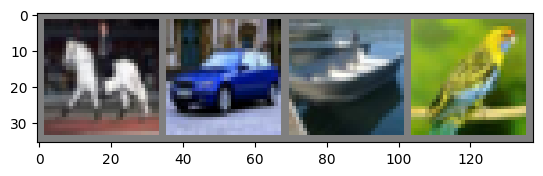

horse car ship bird


In [136]:
def imshow(img):
    # unnormalize
    img = (img /2) + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images, nrow=batch_size))
print(' '.join(f'{classes[labels[i]]}' for i in range(batch_size)) )

In [137]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [146]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3채널, 6개의 출력이됨, 커널사이즈 5x5임 즉 6개의 특징맵을 만듦
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  #배치를 제외하고 한줄로 뽑는다
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)
print(device)


cuda:0


In [139]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [147]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999: # 2천 미니배치마다 출력
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0
print('학습 종료')
# 6.53

[1,  2000] loss: 2.303
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
[2,  2000] loss: 2.303


KeyboardInterrupt: 

In [141]:
torch.save(net.state_dict(), './cifar_net.pth')  # 저장하기

In [142]:
# 불러오기
net = Net().to(device)
net.load_state_dict(torch.load('./cifar_net.pth'))


<All keys matched successfully>

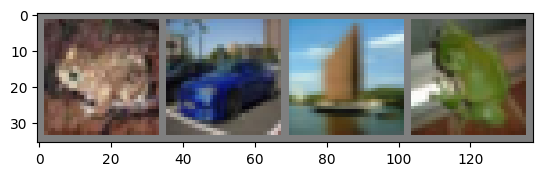

frog car ship frog


In [143]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
plt.show()

print(' '.join(f'{classes[labels[i]]}' for i in range(batch_size)))

In [144]:
# outputs = net(images)
# _, pred = torch.max(outputs, 1)
# print(' '.join(f'{classes[pred[i]]}' for i in range(batch_size)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [145]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.6 %
Accuracy for class: car   is 74.7 %
Accuracy for class: bird  is 48.3 %
Accuracy for class: cat   is 47.7 %
Accuracy for class: deer  is 56.6 %
Accuracy for class: dog   is 40.5 %
Accuracy for class: frog  is 70.5 %
Accuracy for class: horse is 50.9 %
Accuracy for class: ship  is 79.7 %
Accuracy for class: truck is 69.1 %
